<a href="https://colab.research.google.com/github/Pasinduimalsha/Agentic-tut/blob/main/Langraph_stage_3_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install langchain==0.3.24 -q
!pip install langchain-openai -q

In [52]:
!pip install langchain-community -q

In [53]:
!pip install langgraph -q

In [48]:
!pip install duckduckgo-search -qU
!pip install pyowm -qU

In [58]:
!pip install -U ddgs -q

In [24]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [25]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [26]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('API_KEY')

In [38]:
llm = ChatOpenAI(
    model_name="gpt-4o-mini")

In [59]:
from langchain_community.tools import  DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import load_tools

os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHERMAP_API_KEY')
# os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

# Initialize DuckDuckGo search tool
# search_tool = TavilySearch()
search_tool = DuckDuckGoSearchRun()

# Initialize OpenWeatherMap tool
weather = OpenWeatherMapAPIWrapper()

weather_tool = load_tools(["openweathermap-api"], llm)[0]

@tool
def addition(a: int, b: int):
  """This is the addition function  that add 2 numbers"""
  return a + b

@tool
def subtraction(a: int, b: int):
  """This is the subtraction function  that subtract 2 numbers"""
  return a - b

@tool
def multiplication(a: int, b: int):
  """This is the multiplication function  that multiply 2 numbers"""
  return a * b

@tool
def division(a: int, b: int):
  """This is the division function  that divide 2 numbers"""
  return a / b

tools = [addition, subtraction, multiplication, division]


In [60]:
tools = [search_tool, weather_tool]

In [61]:
llm_with_tools = llm.bind_tools(tools)

In [62]:
 def llm_call(state:AgentState) -> AgentState:
  system_prompt = SystemMessage(content=
      "You are an intelligent AI assistant, please answer my query."
       )
  response = llm_with_tools.invoke([system_prompt]+ state["messages"])
  return {"messages": [response]}

In [63]:
def decision_node(state:AgentState):
  message = state["messages"]
  last_message = message[-1]
  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"

In [64]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", llm_call)

tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

workflow.add_edge( START, "agent")
workflow.add_conditional_edges(
    "agent",
    decision_node,
    {
        "continue": "tools",
        "end": END
    }
)
workflow.add_edge("tools", "agent")

app = workflow.compile()


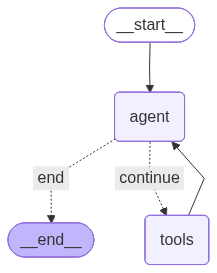

In [65]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [66]:
def print_steam(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
        print(message.content)
    else:
        message.pretty_print()




In [69]:
inputs = {"messages": [("user", "current weather in Embilipitiya")]}

print_steam(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

current weather in Embilipitiya
================================== Ai Message ==================================
Tool Calls:
  open_weather_map (call_hOAWGd7G3NPyv4qoWk2HIOew)
 Call ID: call_hOAWGd7G3NPyv4qoWk2HIOew
  Args:
    location: Embilipitiya
================================= Tool Message =================================
Name: open_weather_map

In Embilipitiya, the current weather is as follows:
Detailed status: broken clouds
Wind speed: 4.71 m/s, direction: 259°
Humidity: 74%
Temperature: 
  - Current: 26.29°C
  - High: 26.29°C
  - Low: 26.29°C
  - Feels like: 26.29°C
Rain: {}
Heat index: None
Cloud cover: 78%
================================== Ai Message ==================================

The current weather in Embilipitiya is as follows:

- **Condition:** Broken clouds
- **Temperature:** 26.29°C (Feels like 26.29°C)
- **Humidity:** 74%
- **Wind Speed:** 4.71 m/s (from the west)
- **Cloud Cove